# Pipeline
Data Preprocessing
- Grab surface smoke data from 1-10-25 00:00 UTC to 1-17-25 00:00 UTC
- Subregion data to the LA metropolitan area
- Preprocess data into 5D tensor for convlstm input
  
Training
- Pass into convlstm
- Examine results
  
Inference
- Pass a sample into the convlstm
- Examine results

# Data Preprocessing

In [1]:
from herbie import Herbie, wgrib2, paint
from herbie.toolbox import EasyMap, ccrs, pc
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
import math
import cv2

In [2]:
# downloads 7 days of data (1-10 to 1-17), 24 hours (00 to 23) -> 168 hours
# not forecasts -- downloading actual hourly updated data
start_day, end_day = 10, 17
start_hour, end_hour = 0, 24
grib_files = []
for day in range(start_day, end_day):
    for hour in range(start_hour, end_hour):
        date = f"2025-01-{str(day).zfill(2)}-{str(hour).zfill(2)}"
        H = Herbie(
            date,
            model="hrrr",
            product="sfc",
        )
        H.download("MASSDEN")
        my_file = H.get_localFilePath("MASSDEN")
        grib_files.append(my_file)
n_frames = len(grib_files)

print(f"Files downloaded: {n_frames}")

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 01:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 02:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 03:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 04:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 05:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 07:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 08:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 09:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 10:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr 

In [3]:
# validate downloads, subregion each grib file, then convert to numpy arrays
lat_bottom, lat_top = 33.6, 34.3
lon_bottom, lon_top = -118.6, -117.9
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

hrrr_subregion_np = np.empty((n_frames, 30, 26))
hrrr_subregion_xarr = [None] * n_frames
for count, file in enumerate(grib_files):
    # subregion the grib files
    idx_file = wgrib2.create_inventory_file(file)    
    subset_file = wgrib2.region(file, extent, name="la_region")

    # print progress
    if ((count + 1) % 10 == 0 or count + 1 == len(grib_files)):
        print(f"{count+1}/{len(grib_files)} files converted.")

    # store as xarray and numpy
    hrrr_xarr = xr.open_dataset(subset_file, engine="cfgrib", decode_timedelta=False)
    hrrr_subregion_xarr[count] = hrrr_xarr
    hrrr_subregion_np[count] = np.flip(hrrr_xarr.mdens.to_numpy(), axis=0)

print(hrrr_subregion_np.shape)

Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_87ef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_03ef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_64ef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_10ef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_47ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_6def9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

10/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_beef9dd4__hrrr.t12z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_5def9dd4__hrrr.t13z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_5aef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_60ef9dd4__hrrr.t15z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_78ef9dd4__hrrr.t16z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_2aef9dd4__hrrr.t17z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_aeef9dd4__hrrr.t18z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

20/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_87ef9dd4__hrrr.t22z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_34ef9dd4__hrrr.t23z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_d7ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_c0ef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_86ef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_afef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_0bef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

30/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_7fef9dd4__hrrr.t08z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_4def9dd4__hrrr.t09z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_b0ef9dd4__hrrr.t10z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_5def9dd4__hrrr.t11z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_b2ef9dd4__hrrr.t12z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_a7ef9dd4__hrrr.t13z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_cdef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

40/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_6def9dd4__hrrr.t20z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_3bef9dd4__hrrr.t21z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_80ef9dd4__hrrr.t22z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_f2ef9dd4__hrrr.t23z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_bbef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_adef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_08ef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

50/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_90ef9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_b6ef9dd4__hrrr.t07z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_9aef9dd4__hrrr.t08z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_3cef9dd4__hrrr.t09z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_44ef9dd4__hrrr.t10z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_e6ef9dd4__hrrr.t11z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_abef9dd4__hrrr.t12z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

60/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_b1ef9dd4__hrrr.t16z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_e9ef9dd4__hrrr.t17z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_afef9dd4__hrrr.t18z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_c8ef9dd4__hrrr.t19z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_fbef9dd4__hrrr.t20z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_0aef9dd4__hrrr.t21z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_18ef9dd4__hrrr.t22z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

70/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_0fef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_c2ef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_9bef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_34ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_17ef9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_1bef9dd4__hrrr.t07z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_0def9dd4__hrrr.t08z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

80/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_c4ef9dd4__hrrr.t12z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_ddef9dd4__hrrr.t13z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_f3ef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_b3ef9dd4__hrrr.t15z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_53ef9dd4__hrrr.t16z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_d3ef9dd4__hrrr.t17z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_d6ef9dd4__hrrr.t18z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

90/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_4cef9dd4__hrrr.t22z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_21ef9dd4__hrrr.t23z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_d5ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_1def9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_08ef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_c4ef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_beef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

100/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_efef9dd4__hrrr.t08z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_a7ef9dd4__hrrr.t09z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_beef9dd4__hrrr.t10z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_10ef9dd4__hrrr.t11z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_14ef9dd4__hrrr.t12z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_43ef9dd4__hrrr.t13z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_73ef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

110/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_f8ef9dd4__hrrr.t18z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_3def9dd4__hrrr.t19z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_eeef9dd4__hrrr.t20z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_1cef9dd4__hrrr.t21z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_82ef9dd4__hrrr.t22z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_63ef9dd4__hrrr.t23z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_6def9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

120/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_95ef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_5bef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_fbef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_deef9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_3def9dd4__hrrr.t07z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_15ef9dd4__hrrr.t08z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_12ef9dd4__hrrr.t09z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

130/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_8eef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_16ef9dd4__hrrr.t15z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_82ef9dd4__hrrr.t16z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_91ef9dd4__hrrr.t17z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_7bef9dd4__hrrr.t18z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_22ef9dd4__hrrr.t19z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_d7ef9dd4__hrrr.t20z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

140/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_45ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_e3ef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_faef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_0eef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_bdef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_a8ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_37ef9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

150/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_35ef9dd4__hrrr.t10z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_18ef9dd4__hrrr.t11z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_b5ef9dd4__hrrr.t12z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_daef9dd4__hrrr.t13z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_8eef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_91ef9dd4__hrrr.t15z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_2fef9dd4__hrrr.t16z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

160/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_5bef9dd4__hrrr.t19z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_aaef9dd4__hrrr.t20z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_3bef9dd4__hrrr.t21z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_90ef9dd4__hrrr.t22z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_70ef9dd4__hrrr.t23z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file


168/168 files converted.
(168, 30, 26)


In [4]:
# interpolate and create channel axis
frames = np.empty(shape=(n_frames, 40, 40, 1))
for i, frame in enumerate(hrrr_subregion_np):
    new_frame = cv2.resize(frame, (40, 40))
    new_frame = np.reshape(new_frame, (40, 40, 1)) # (row, col, channel)
    frames[i] = new_frame

print(f"Shape of a frame: {frames.shape}")

# create samples from frames
def sliding_window_of(frames, sample_size, rows, cols, channels):
    n_samples = len(frames) - sample_size
    samples = np.empty((n_samples, sample_size, rows, cols, channels))
    for i in range(n_samples):
        samples[i] = np.array([frames[j] for j in range(i, i + sample_size)])
    return samples

complete_dataset = sliding_window_of(frames=frames, sample_size=6, rows=40, cols=40, channels=1)
print(f"Shape of the final input: {complete_dataset.shape}")

Shape of a frame: (168, 40, 40, 1)
Shape of the final input: (162, 6, 40, 40, 1)


**Due to next-frame prediction, if we want samples of size 5, we need to create sampels of size 6 so that we have samples with frames x=1,5 and y=2, 6**

# Training
https://keras.io/examples/vision/conv_lstm/

In [5]:
# split data into training and validation sets
split_idx = int(len(complete_dataset) * 0.75)
train_dataset, val_dataset = complete_dataset[0:split_idx], complete_dataset[split_idx:]

# standard scale data
def std_scale(data):
    mean = data.mean()
    var = data.var()
    return (data - mean) / math.sqrt(var)
    
# scale separately
train_dataset = std_scale(train_dataset)
val_dataset = std_scale(val_dataset)

# next-frame prediction: x = frames (0, n-1), y = frames (1, n)
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (121, 5, 40, 40, 1), (121, 5, 40, 40, 1)
Validation Dataset Shapes: (41, 5, 40, 40, 1), (41, 5, 40, 40, 1)


Displaying frames for example 102.


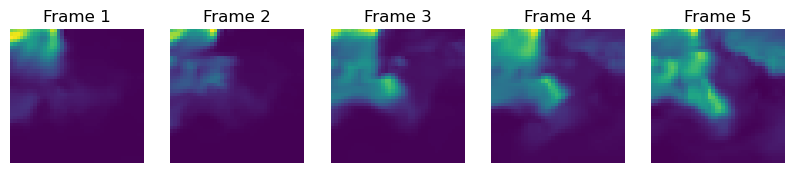

In [6]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(1, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
np.random.seed(42)
rand_sample = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[rand_sample][idx]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {rand_sample}.")
plt.show()

In [7]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

2025-03-30 13:56:50.314275: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 13:56:50.322314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743368210.332678   24575 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743368210.336050   24575 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-30 13:56:50.345948: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [8]:
seq = Sequential()

seq.add(
    InputLayer(shape=(5, 40, 40, 1))
)

seq.add(
    ConvLSTM2D(
            filters=15, 
            kernel_size=(3, 3),
            padding='same', return_sequences=True
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same', 
        data_format='channels_last'
    )
)


seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same', 
        data_format='channels_last'
    )
)

seq.compile(loss='mean_absolute_error', optimizer='adam')
seq.summary()

I0000 00:00:1743368211.478891   24575 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6414 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 15)  │         8,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 40, 40, 1)   │           406 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,991 (273.40 KB)

 Trainable params: 69,991 (273.40 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
seq.fit(x_train, y_train, batch_size=16, epochs=150)

Epoch 1/150


I0000 00:00:1743368213.919992   27770 service.cc:148] XLA service 0x758a0c01c040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743368213.920011   27770 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-03-30 13:56:53.973542: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743368214.236061   27770 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-03-30 13:56:54.604016: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[16,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backen

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2002

I0000 00:00:1743368216.171275   27770 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-03-30 13:56:56.810005: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[9,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[9,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[9,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - loss: 0.1989
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1761
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1711
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1728
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1546
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1498
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1478
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1386
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1410
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1382
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1331
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1332
Epoch 13/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1300
Epoch 14/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1299
Epoch 15/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1280
Epoch 16/150
8/8 ━━━━━━━━━━━━━

# Inference

## Results with validation set

In [10]:
# infer
y_hat = seq.predict(x_val, verbose=0)
print("Shape of test: ", y_val.shape)
print("Shape of predictions: ", y_hat.shape)

# calculate metrics
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def rmse_percent(y_true, y_pred):
    return (rmse(y_true, y_hat) / np.mean(y_true)) * 100

# print results
print("RESULTS")
print("---------------------------------------------------------------------------")
print("Root mean squared error: ", rmse(y_val, y_hat))
print("RMSE as % of mean: ", rmse_percent(y_val, y_hat))
print("---------------------------------------------------------------------------")

for i in range(5):
    print("Frame " + str((i+1)) + " (Hour " + str((i+1)) + ") Raw RMSE: ", rmse(y_val[i,:], y_hat[i,:]))
    print("Frame " + str((i+1)) + " (Hour " + str((i+1)) + ") RMSE Percent Error of Mean: ", rmse_percent(y_val[i,:], y_hat[i,:]), "%\n")

2025-03-30 13:57:30.864017: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,40,40]{3,2,1,0}, f32[15,1,3,3]{3,2,1,0}, f32[15]{0}, f32[32,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-30 13:57:30.915349: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[32,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01-

Shape of test:  (41, 5, 40, 40, 1)
Shape of predictions:  (41, 5, 40, 40, 1)
RESULTS
---------------------------------------------------------------------------
Root mean squared error:  0.546726044847649
RMSE as % of mean:  4295.099211740502
---------------------------------------------------------------------------
Frame 1 (Hour 1) Raw RMSE:  0.9052702588804711
Frame 1 (Hour 1) RMSE Percent Error of Mean:  961.3698185175622 %

Frame 2 (Hour 2) Raw RMSE:  0.8119639036187141
Frame 2 (Hour 2) RMSE Percent Error of Mean:  480.7151100379692 %

Frame 3 (Hour 3) Raw RMSE:  0.6925294413742247
Frame 3 (Hour 3) RMSE Percent Error of Mean:  380.32470402202296 %

Frame 4 (Hour 4) Raw RMSE:  0.6108728543768284
Frame 4 (Hour 4) RMSE Percent Error of Mean:  354.7592457830453 %

Frame 5 (Hour 5) Raw RMSE:  0.5324361248281951
Frame 5 (Hour 5) RMSE Percent Error of Mean:  392.2457397439722 %



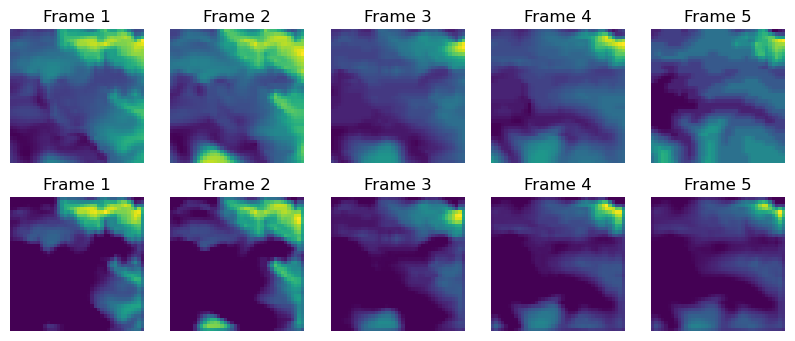

In [11]:
# examine results
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# plot original frames
np.random.seed(42)
rand_sample = np.random.choice(range(len(y_val)), size=1)[0]
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(y_val[rand_sample][idx]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# plot predicted frames
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(y_hat[rand_sample][idx]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

plt.show()

Goal: take 5 frames, infer the next 5 frames.

## Testing next-5 frame prediction

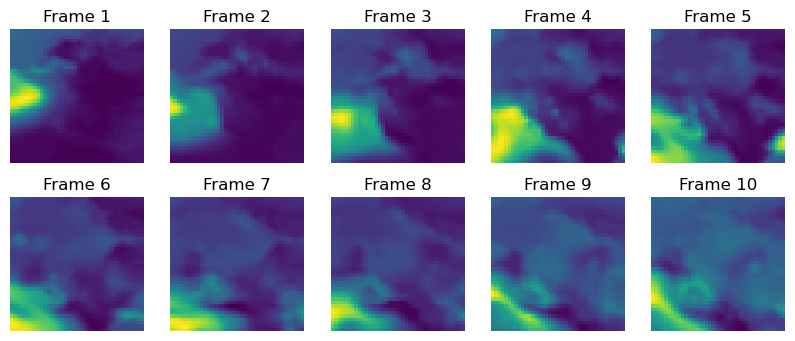

In [12]:
# test inference
# Select a random example from the validation dataset.
# expected: 5 samples ahead
idx = 0
sample = y_val[idx]
expected = y_val[idx+5]

# stitched together, they should be 10 continuous frames
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(sample[idx]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(expected[idx]))
    ax.set_title(f"Frame {idx + 1 + 5}")
    ax.axis("off")

plt.show()

Basic idea here: pass in 5 frames, predict the next 5 frames. We test by picking a sample, then picking the next 5 samples over, which should make a continuous 10 frames.
- We pass in 5 frames, predict the next. The firsst frame is then removed, and the predicted frame is concatenated
- This means the next prediction uses now 4 real frames + 1 predicted frame to predict the 6th frame.
- This continues until 5 frames are predicted, where the last one will have 1 real frame and 4 predicted frames to predict the 10th frame.

2025-03-30 13:57:32.612837: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[1,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
(10, 40, 40, 1)


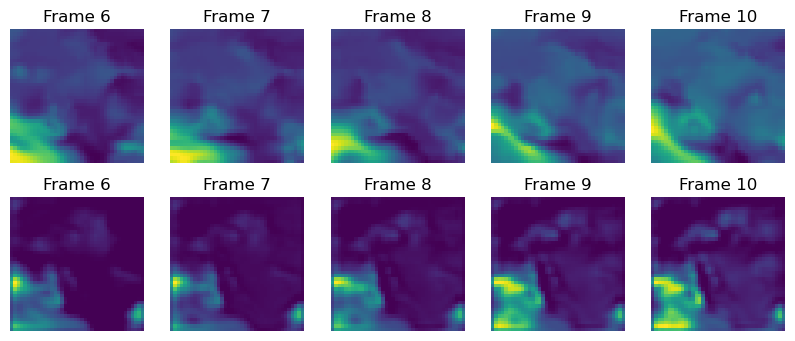

In [13]:
# Pick the first/last ten frames from the example.
frames = sample
original_frames = expected

# Predict a new set of 5 frames.
for _ in range(5):
    # Extract the model's prediction and post-process it.
    new_prediction = seq.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)
print(frames.shape)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]))
    ax.set_title(f"Frame {idx + 6}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[5:]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]))
    ax.set_title(f"Frame {idx + 6}")
    ax.axis("off")

# Display the figure.
plt.show()

Ignoring the first 5 real frames, we plot the next 5 real frames, then the next row plots the 5 predicted frames.

# Discussion
- RMSE is giga high, is it b/c of sparseness? The predictions look good on hotspots but not elsewhere.
- Loss converges very fast, will need to do hyperparameter tuning and model adjustments (batch normalizations? filters?)